# 2D Virial Distance Properties Plots

### Importing Tables

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

import seaborn as sns

from scipy import stats

In [2]:
dwarf_table = Table.read('dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549


In [3]:
gal_table = Table.read('gal_table.txt', format = 'ascii.commented_header')
gal_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID#,BPTclass,gamma_ratio
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32
-99.0,0.0,146.714215072841,-1.0412800233313741,0.021222278475761414,-19.30365562438965,2.3124398291110992,nan,nan,nan,nan,nan,nan,nan,nan,9,0,nan,1
1.0,1.0,146.6285851269414,-0.7651620976591762,0.0646563172340393,-19.97649574279785,2.976039946079254,-11.241625785827637,nan,nan,nan,nan,nan,nan,nan,2,1,3.0,2
-99.0,0.0,146.63170644325592,-0.9883467023052999,0.05265425145626068,-18.431812286376953,1.7119742929935455,nan,nan,nan,nan,nan,nan,nan,nan,2,2,nan,1
1.0,1.0,146.9341288729797,-0.6704053610430766,0.12127048522233963,-21.559162139892578,3.0934733152389526,-11.71275806427002,nan,nan,nan,nan,nan,nan,nan,9,3,-1.0,2
-99.0,1.0,146.9634997327016,-0.5447758299302171,0.055980585515499115,-19.10099220275879,2.044341266155243,nan,nan,nan,nan,nan,nan,nan,nan,2,4,nan,1


## Getting values for Difference in Metallicity and N/O Ratio (Target - Neighboring)

In [4]:
t3mask = dwarf_table['t3'] < 3  # Makes a boolean selection mask (numpy array)
dwarf_t3= dwarf_table[t3mask]

In [5]:
#creating the new columns
dwarf_t3['2D_vir_Z12logOH_diff'] = np.nan
dwarf_t3['2D_vir_logNO_diff'] = np.nan

In [6]:
for i in range(len(dwarf_t3)):
    
    di = gal_table['ID#'] == dwarf_t3['2D_neighbor_ID_vir'][i] #finding neighboring galaxy in the large table
    
    dwarf_t3['2D_vir_Z12logOH_diff'][i] = dwarf_t3['Z12logOH'][i] - gal_table['Z12logOH'][di]
    dwarf_t3['2D_vir_logNO_diff'][i] = dwarf_t3['logNO'][i] - gal_table['logNO'][di]

In [7]:
# Separating into Void, Wall, or Other Dwarf Galaxies

dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)


dwarf_wall_t3 = dwarf_t3['vflag_VF']==0
dwarf_void_t3 = dwarf_t3['vflag_VF']==1
dwarf_other_t3 = ~(dwarf_wall_t3 | dwarf_void_t3)

## Profile Histogram Function

In [8]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

# Profile Historgrams and Linear Regressions

## Color (u-r


### Profile Histogram

In [9]:
sfd = dwarf_table['BPTclass'] == 1
sfd_t3 = dwarf_t3['BPTclass'] == 1

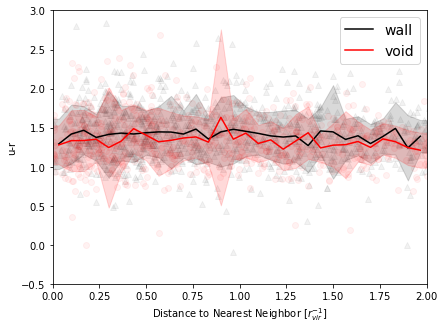

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals = dwarf_table['u_r'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='u-r', xlim=([0,2]), ylim=([-0.5,3]));
    ax.legend();

    fig.savefig('sfd_ur_2D_vir_PH.png')
    
    #fig.savefig('ur_2D_vir_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


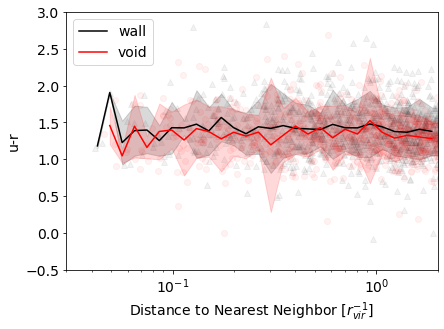

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals = dwarf_table['u_r'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.03),np.log10(2),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)
    
   

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='u-r', xlim=([0.03,2]), ylim=([-0.5,3]));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_ur_2D_vir_PH_log.png')
    #fig.savefig('ur_2D_vir_PH_log.png')

### Linear Regression

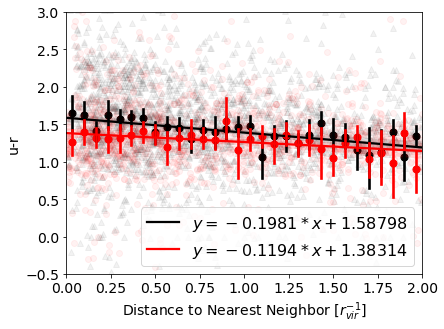

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist_vir'][select]
    vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})    
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='u-r', xlim=(0,2), ylim=(-0.5,3));
        
    ax.legend(prop={'size': 16})
        
    #fig.savefig('sfd_ur_2D_vir_LR.png')
    #fig.savefig('ur_2D_vir_LR.png')

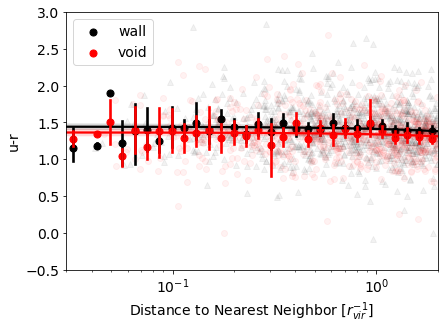

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals_all = dwarf_table['u_r'][select & sfd]
    
    #d_all = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.03),np.log10(2),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='u-r', xlim=(0.03,2), ylim=(-0.5,3));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_ur_2D_vir_LR_log.png')
    
    #fig.savefig('ur_2D_vir_LR_log.png')

## Star Formation Rate (sSFR)

### Profile Histogram

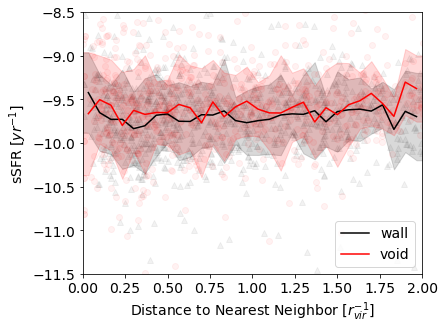

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals = dwarf_table['sSFR'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0,2]), ylim=(-11.5,-8.5));
    ax.legend();

    fig.savefig('sfd_sSFR_2D_vir_PH.png')
    
    #fig.savefig('sSFR_2D_vir_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


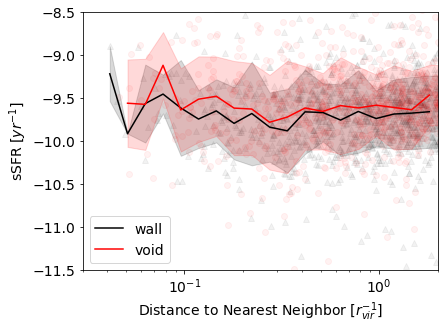

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals = dwarf_table['sSFR'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.03),np.log10(2),21), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0.03,2]), ylim=(-11.5,-8.5));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_sSFR_2D_vir_PH_log.png')
    #fig.savefig('sSFR_2D_vir_PH_log.png')

### Linear Regression

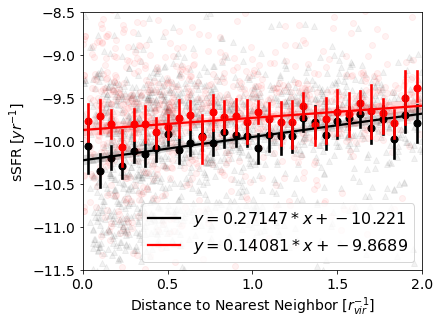

In [32]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
mpl.rc('font', size=16)

d_max = 2
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    #vals_all = dwarf_table['sSFR'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist_vir'][select]
    vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])    
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})    
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,2), ylim=(-11.5,-8.5));
        
    ax.legend(prop={'size': 16})
        
    #fig.savefig('sfd_sSFR_2D_vir_LR.png')
    #fig.savefig('sSFR_2D_vir_LR.png')

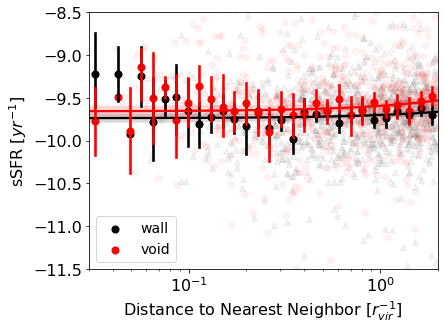

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['2D_neighbor_dist_vir'][select & sfd]
    vals_all = dwarf_table['sSFR'][select & sfd]
    
    #d_all = dwarf_table['2D_neighbor_dist_vir'][select]
    #vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.03),np.log10(2),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0.03,2), ylim=(-11.5,-8.5));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_sSFR_2D_vir_LR_log.png')
    #fig.savefig('sSFR_2D_vir_LR_log.png')

## Metallicity (12 + log(O/H))

### Profile Histogram


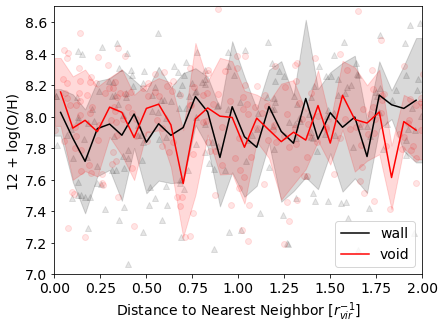

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=([0,2]), ylim=(7,8.7));
    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_vir_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


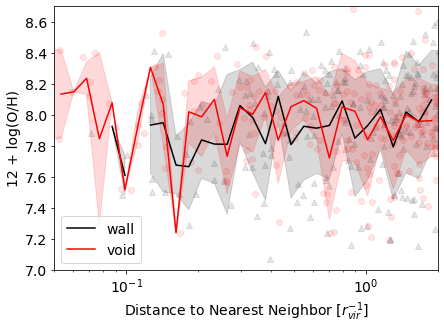

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.05),np.log10(2),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=([0.05,2]), ylim=(7,8.7));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_vir_PH_log.png')

### Linear Regression


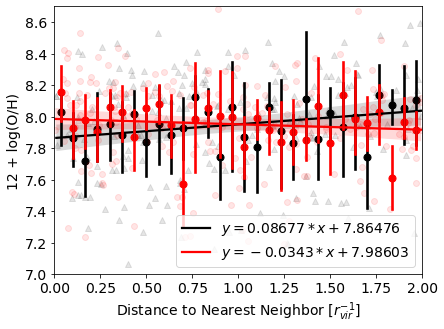

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})   
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=(0,2), ylim=(7,8.7));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_2D_vir_LR.png')

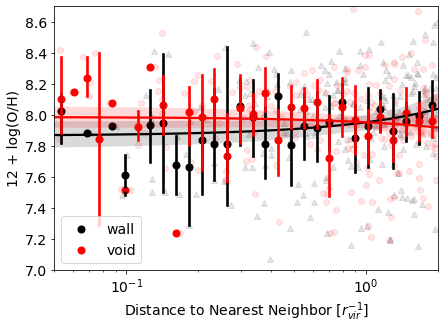

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.05),np.log10(2),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=(0.05,2), ylim=(7,8.7));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    fig.savefig('sfd_Z12logOH_2D_vir_LR_log.png')

## Metallicity Difference (target - neighbor)

### Profile Histogram


C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


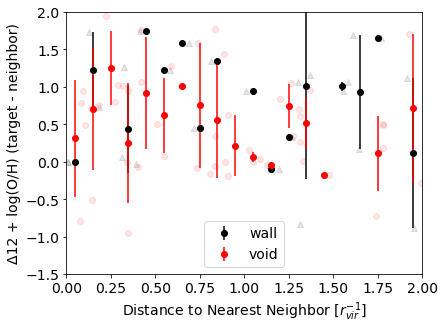

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['2D_vir_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,3,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=([0,2]), ylim=(-1.5,2));
    ax.legend();

    fig.savefig('sfd_Z12logOH_diff_2D_vir_PH.png')

### Linear Regression


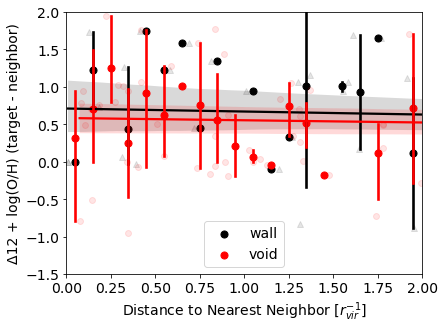

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['2D_vir_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,3,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=(0,2), ylim=(-1.5,2));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_diff_2D_vir_LR.png')

## N/O Ratio

### Profile Histogram

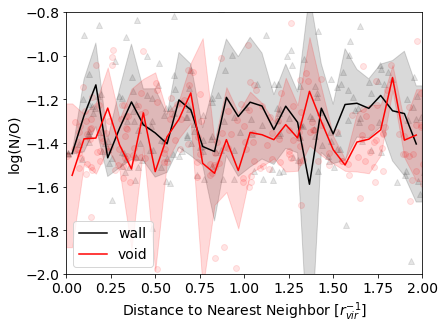

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    
    
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='log(N/O)', xlim=([0,2]), ylim=(-2,-0.8));
    ax.legend();

    fig.savefig('sfd_logNO_2D_vir_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


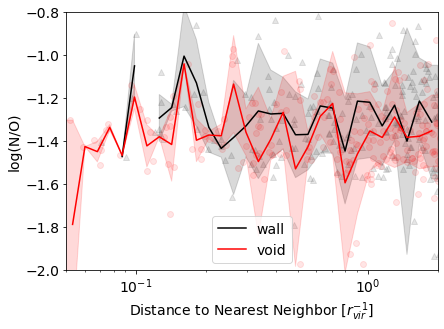

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.05),np.log10(2),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='log(N/O)', xlim=([0.05,2]), ylim=(-2,-0.8));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_logNO_2D_vir_PH_log.png')

### Linear Regression

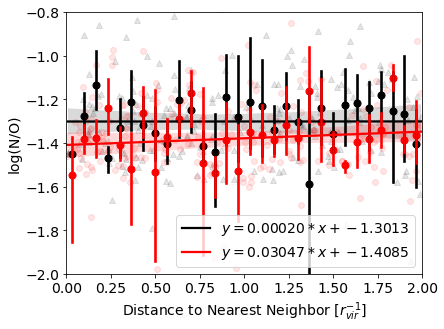

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})    
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='log(N/O)', xlim=(0,2), ylim=(-2,-0.8));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_vir_LR.png')

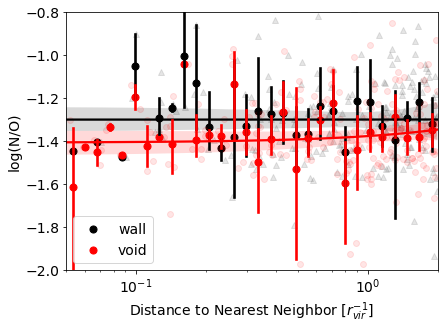

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 2
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= d_max)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    logbins = np.logspace(np.log10(0.05),np.log10(2),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='log(N/O)',
           xlim=(0.05,2), ylim=(-2,-0.8));
    
    ax.set_xscale('log')
    
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_vir_LR_log.png')

## N/O Ratio Difference (target - neighbor)

### Profile Histogram

C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_19104\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


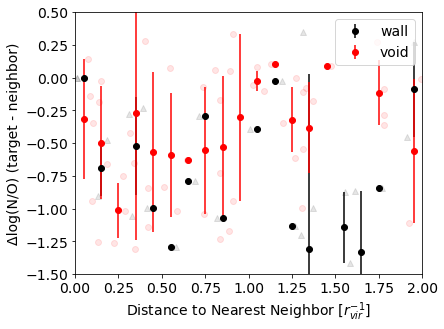

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['2D_vir_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,3,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)

    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=([0,2]), ylim=(-1.5,0.5));
    ax.legend();

    fig.savefig('sfd_logNO_diff_2D_vir_PH.png')

### Linear Regression

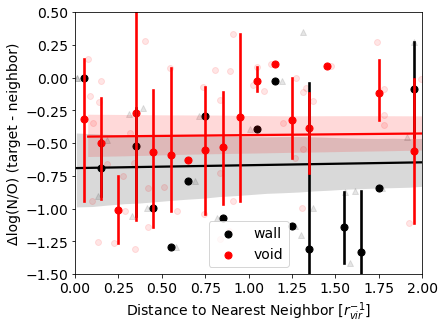

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist_vir'][select & sfd_t3]
    vals = dwarf_t3['2D_vir_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,3,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$r^{-1}_{vir}]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=(0,2), ylim=(-1.5,0.5));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_diff_2D_vir_LR.png')